2일차 오후 실습: 확률분포와 데이터 전처리

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import warnings
warnings.filterwarnings('ignore')
import matplotlib.font_manager as fm

# 폰트 파일 직접 찾기
nanum_font = None
for font in fm.fontManager.ttflist:
    if 'NanumGothic' in font.name:
        nanum_font = font.fname
        break

if nanum_font:
    font_prop = fm.FontProperties(fname=nanum_font)
    plt.rcParams['font.family'] = font_prop.get_name()

plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8')

1. 정규분포 시뮬레이션과 성질 확인

1.1 정규분포 샘플 생성 및 시각화

In [10]:
import matplotlib.font_manager as fm

# 정확한 폰트 이름 찾기
for font in fm.fontManager.ttflist:
    if 'Nanum' in font.name:
        print(f"폰트명: {font.name}, 파일: {font.fname}")

폰트명: NanumGothic, 파일: C:\Windows\Fonts\NanumGothic.ttf
폰트명: NanumMyeongjo, 파일: C:\Windows\Fonts\NanumMyeongjoBold.ttf
폰트명: NanumGothic, 파일: C:\Windows\Fonts\NanumGothicBold.ttf
폰트명: NanumMyeongjo, 파일: C:\Windows\Fonts\NanumMyeongjoExtraBold.ttf
폰트명: NanumGothic, 파일: C:\Windows\Fonts\NanumGothicLight.ttf
폰트명: NanumMyeongjo, 파일: C:\Windows\Fonts\NanumMyeongjo.ttf
폰트명: NanumGothic, 파일: C:\Windows\Fonts\NanumGothicExtraBold.ttf


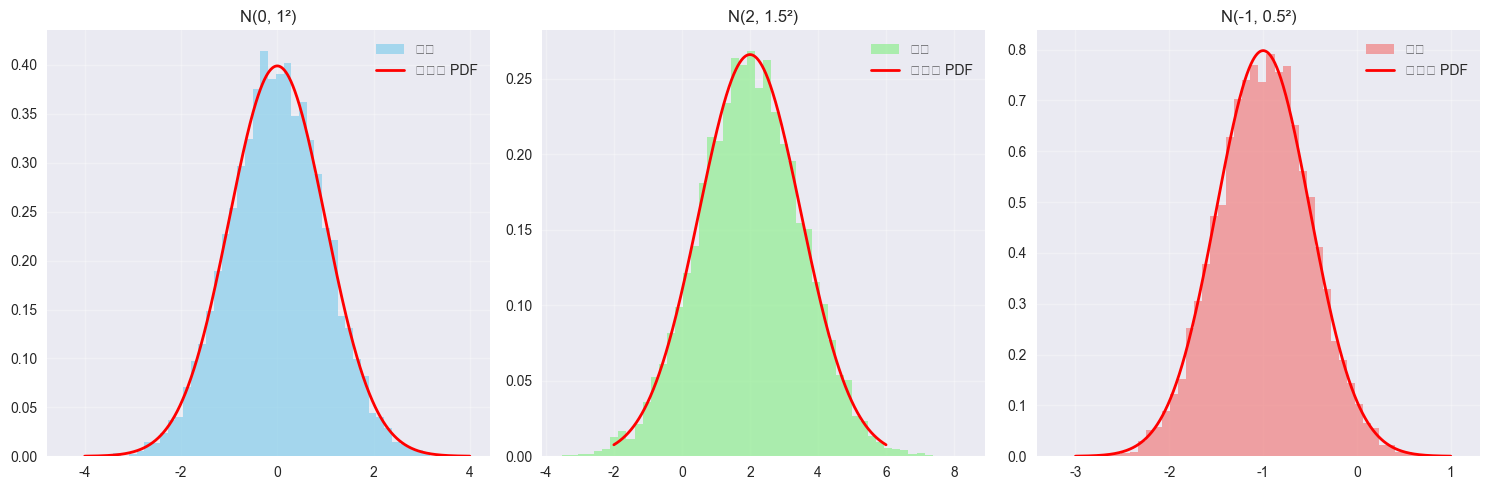


정규분포 통계량 확인:
N(0, 1): 표본평균=-0.002 (이론값=0), 표본표준편차=0.991 (이론값=1)
N(2, 1.5²): 표본평균=2.005 (이론값=2), 표본표준편차=1.514 (이론값=1.5)
N(-1, 0.5²): 표본평균=-0.991 (이론값=-1), 표본표준편차=0.498 (이론값=0.5)


In [11]:
def simulate_normal_distribution():
    """정규분포의 기본 성질을 시뮬레이션으로 확인"""
    
    # 서로 다른 모수의 정규분포 생성
    mu1, sigma1 = 0, 1      # 표준정규분포
    mu2, sigma2 = 2, 1.5    # 평균 이동, 분산 증가
    mu3, sigma3 = -1, 0.5   # 평균 감소, 분산 감소
    
    # 샘플 생성
    n_samples = 10000
    samples1 = np.random.normal(mu1, sigma1, n_samples)
    samples2 = np.random.normal(mu2, sigma2, n_samples)
    samples3 = np.random.normal(mu3, sigma3, n_samples)
    
    # 시각화
    plt.figure(figsize=(15, 5))
    
    # 히스토그램과 이론적 PDF 비교
    plt.subplot(1, 3, 1)
    plt.hist(samples1, bins=50, density=True, alpha=0.7, color='skyblue', label='샘플')
    x = np.linspace(-4, 4, 1000)
    plt.plot(x, stats.norm.pdf(x, mu1, sigma1), 'r-', linewidth=2, label='이론적 PDF')
    plt.title(f'N({mu1}, {sigma1}²)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 2)
    plt.hist(samples2, bins=50, density=True, alpha=0.7, color='lightgreen', label='샘플')
    x = np.linspace(-2, 6, 1000)
    plt.plot(x, stats.norm.pdf(x, mu2, sigma2), 'r-', linewidth=2, label='이론적 PDF')
    plt.title(f'N({mu2}, {sigma2}²)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    plt.hist(samples3, bins=50, density=True, alpha=0.7, color='lightcoral', label='샘플')
    x = np.linspace(-3, 1, 1000)
    plt.plot(x, stats.norm.pdf(x, mu3, sigma3), 'r-', linewidth=2, label='이론적 PDF')
    plt.title(f'N({mu3}, {sigma3}²)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 통계량 확인
    print("\n정규분포 통계량 확인:")
    distributions = [
        (samples1, mu1, sigma1, "N(0, 1)"),
        (samples2, mu2, sigma2, "N(2, 1.5²)"),
        (samples3, mu3, sigma3, "N(-1, 0.5²)")
    ]
    
    for samples, true_mu, true_sigma, name in distributions:
        sample_mean = np.mean(samples)
        sample_std = np.std(samples, ddof=1)
        print(f"{name}: 표본평균={sample_mean:.3f} (이론값={true_mu}), "
              f"표본표준편차={sample_std:.3f} (이론값={true_sigma})")

simulate_normal_distribution()


1.2 중심극한정리 시각화


중심극한정리 시연:
------------------------------


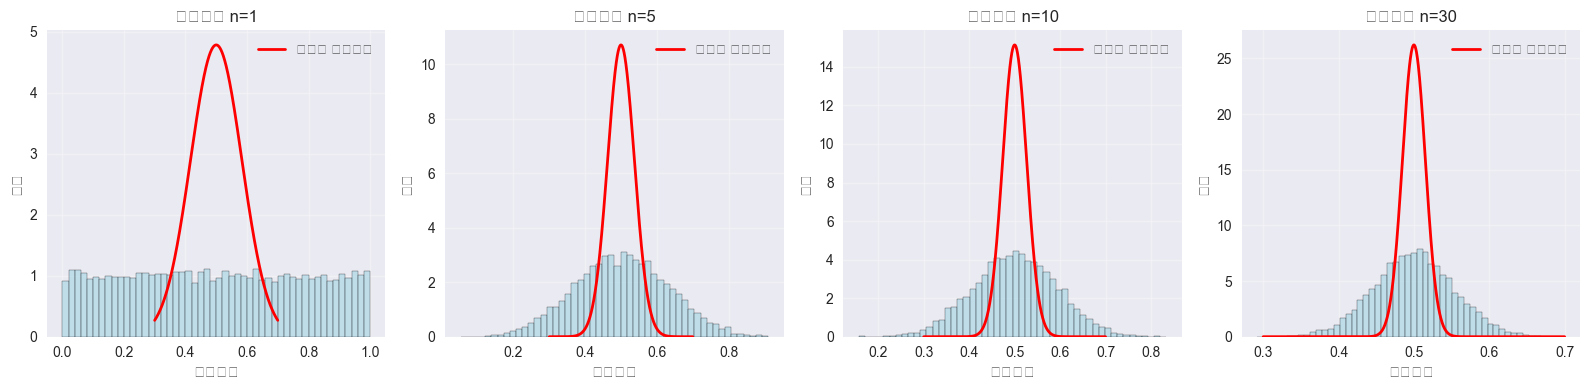

→ 표본크기가 증가할수록 정규분포에 가까워짐을 확인


In [12]:
def demonstrate_central_limit_theorem():
    """중심극한정리를 시각화로 확인"""
    print("\n중심극한정리 시연:")
    print("-" * 30)
    
    # 원래 분포: 균등분포 (비정규분포)
    def uniform_samples(n):
        return np.random.uniform(0, 1, n)
    
    sample_sizes = [1, 5, 10, 30]
    n_experiments = 10000
    
    plt.figure(figsize=(16, 4))
    
    for i, n in enumerate(sample_sizes):
        plt.subplot(1, 4, i+1)
        
        # n개씩 뽑아서 평균 계산을 반복
        sample_means = []
        for _ in range(n_experiments):
            samples = uniform_samples(n)
            sample_means.append(np.mean(samples))
        
        # 히스토그램
        plt.hist(sample_means, bins=50, density=True, alpha=0.7, 
                color='lightblue', edgecolor='black')
        
        # 이론적 정규분포 (중심극한정리)
        theoretical_mean = 0.5  # 균등분포 U(0,1)의 평균
        theoretical_std = (1/12) / np.sqrt(n)  # 균등분포의 분산=1/12
        
        x = np.linspace(0.3, 0.7, 1000)
        plt.plot(x, stats.norm.pdf(x, theoretical_mean, theoretical_std), 
                'r-', linewidth=2, label='이론적 정규분포')
        
        plt.title(f'표본크기 n={n}')
        plt.xlabel('표본평균')
        plt.ylabel('밀도')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("→ 표본크기가 증가할수록 정규분포에 가까워짐을 확인")

demonstrate_central_limit_theorem()

2. 베르누이 분포와 이항분포 실습

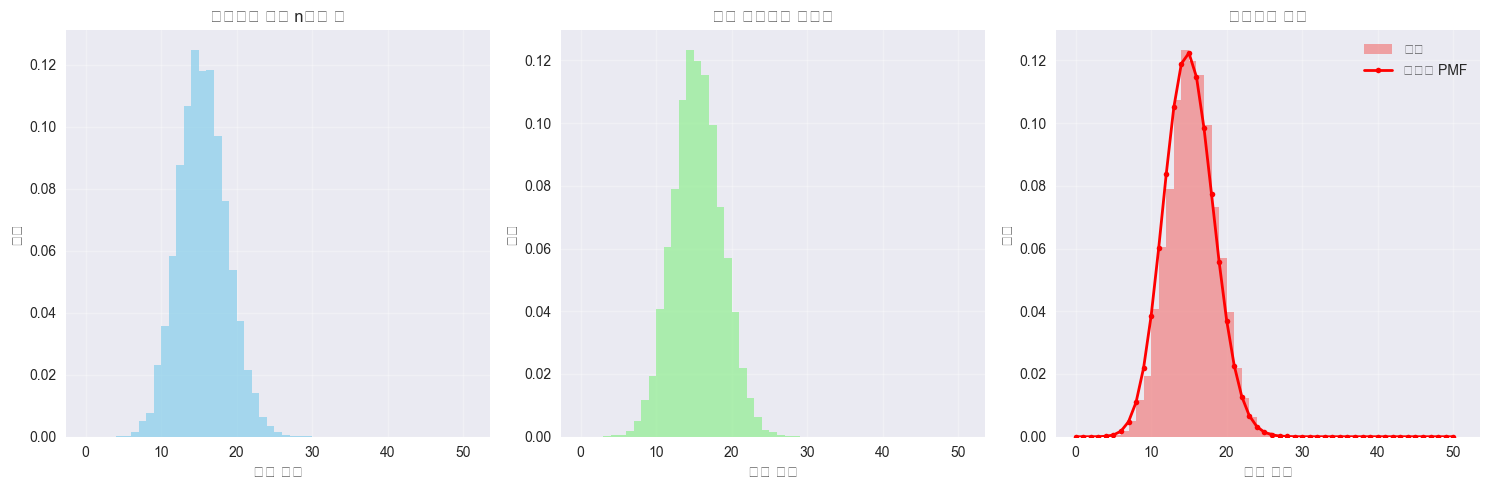

이항분포 B(50, 0.3) 통계량:
이론적 평균: 15.00
이론적 분산: 10.50
샘플 평균: 14.98
샘플 분산: 10.44


In [13]:
def simulate_bernoulli_binomial():
    """베르누이 분포와 이항분포의 관계 시뮬레이션"""
    
    p = 0.3  # 성공 확률
    n_trials = 50  # 시행 횟수
    n_experiments = 10000
    
    # 베르누이 시행을 n번 반복한 결과
    binomial_samples = []
    for _ in range(n_experiments):
        # n번의 베르누이 시행
        bernoulli_trials = np.random.binomial(1, p, n_trials)
        binomial_samples.append(np.sum(bernoulli_trials))
    
    # 직접 이항분포에서 샘플링
    direct_binomial = np.random.binomial(n_trials, p, n_experiments)
    
    plt.figure(figsize=(15, 5))
    
    # 1. 베르누이 시행 결과 분포
    plt.subplot(1, 3, 1)
    plt.hist(binomial_samples, bins=range(0, n_trials+2), density=True, 
             alpha=0.7, color='skyblue', label='베르누이 합')
    plt.xlabel('성공 횟수')
    plt.ylabel('확률')
    plt.title('베르누이 시행 n번의 합')
    plt.grid(True, alpha=0.3)
    
    # 2. 직접 이항분포 샘플링
    plt.subplot(1, 3, 2)
    plt.hist(direct_binomial, bins=range(0, n_trials+2), density=True, 
             alpha=0.7, color='lightgreen', label='이항분포')
    plt.xlabel('성공 횟수')
    plt.ylabel('확률')
    plt.title('직접 이항분포 샘플링')
    plt.grid(True, alpha=0.3)
    
    # 3. 이론적 이항분포와 비교
    plt.subplot(1, 3, 3)
    x = np.arange(0, n_trials+1)
    theoretical_pmf = stats.binom.pmf(x, n_trials, p)
    
    plt.hist(direct_binomial, bins=range(0, n_trials+2), density=True, 
             alpha=0.7, color='lightcoral', label='샘플')
    plt.plot(x, theoretical_pmf, 'ro-', linewidth=2, markersize=4, 
             label='이론적 PMF')
    plt.xlabel('성공 횟수')
    plt.ylabel('확률')
    plt.title('이론값과 비교')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 통계량 비교
    print(f"이항분포 B({n_trials}, {p}) 통계량:")
    print(f"이론적 평균: {n_trials * p:.2f}")
    print(f"이론적 분산: {n_trials * p * (1-p):.2f}")
    print(f"샘플 평균: {np.mean(direct_binomial):.2f}")
    print(f"샘플 분산: {np.var(direct_binomial):.2f}")

simulate_bernoulli_binomial()

3. 다항분포 시뮬레이션 (딥러닝 연결)

소프트맥스 변환:
로짓: [2.  1.  0.5]
확률: [0.62853172 0.2312239  0.14024438]
확률 합: 1.000000


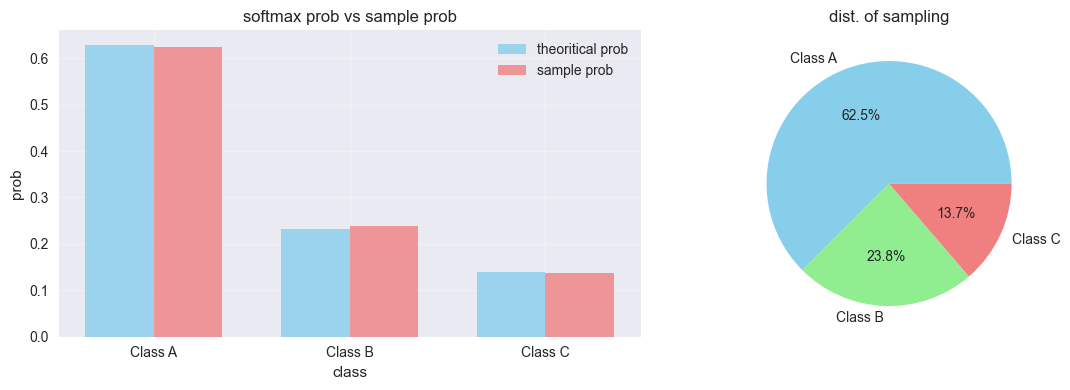

In [15]:
def simulate_multinomial_softmax():
    """다항분포와 소프트맥스의 관계 시뮬레이션"""
    
    # 3개 클래스 분류 문제
    n_classes = 3
    class_names = ['Class A', 'Class B', 'Class C']
    
    # 소프트맥스 입력 (로짓)
    logits = np.array([2.0, 1.0, 0.5])
    
    # 소프트맥스 확률 계산
    exp_logits = np.exp(logits)
    softmax_probs = exp_logits / np.sum(exp_logits)
    
    print("소프트맥스 변환:")
    print(f"로짓: {logits}")
    print(f"확률: {softmax_probs}")
    print(f"확률 합: {np.sum(softmax_probs):.6f}")
    
    # 다항분포 샘플링
    n_samples = 10000
    samples = np.random.multinomial(1, softmax_probs, n_samples)
    
    # 각 클래스별 선택 횟수
    class_counts = np.sum(samples, axis=0)
    sample_probs = class_counts / n_samples
    
    # 시각화
    plt.figure(figsize=(12, 4))
    
    # 1. 확률 비교
    plt.subplot(1, 2, 1)
    x = np.arange(n_classes)
    width = 0.35
    
    plt.bar(x - width/2, softmax_probs, width, label='theoritical prob', 
            color='skyblue', alpha=0.8)
    plt.bar(x + width/2, sample_probs, width, label='sample prob', 
            color='lightcoral', alpha=0.8)
    
    plt.xlabel('class')
    plt.ylabel('prob')
    plt.title('softmax prob vs sample prob')
    plt.xticks(x, class_names)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. 샘플링 결과 분포
    plt.subplot(1, 2, 2)
    plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', 
            colors=['skyblue', 'lightgreen', 'lightcoral'])
    plt.title('dist. of sampling')
    
    plt.tight_layout()
    plt.show()

simulate_multinomial_softmax()


4. 데이터 전처리 방법들의 통계적 효과 분석


normal dist 데이터 분석:
----------------------------------------
original: 평균= 50.29, 표준편차= 14.68, 왜도=  0.12
Z-score : 평균=  0.00, 표준편차=  1.00, 왜도=  0.12
Min-Max : 평균=  0.46, 표준편차=  0.14, 왜도=  0.12
Robust  : 평균= -0.00, 표준편차=  0.76, 왜도=  0.12
Log transform: 평균=  3.87, 표준편차=  0.34, 왜도= -1.90


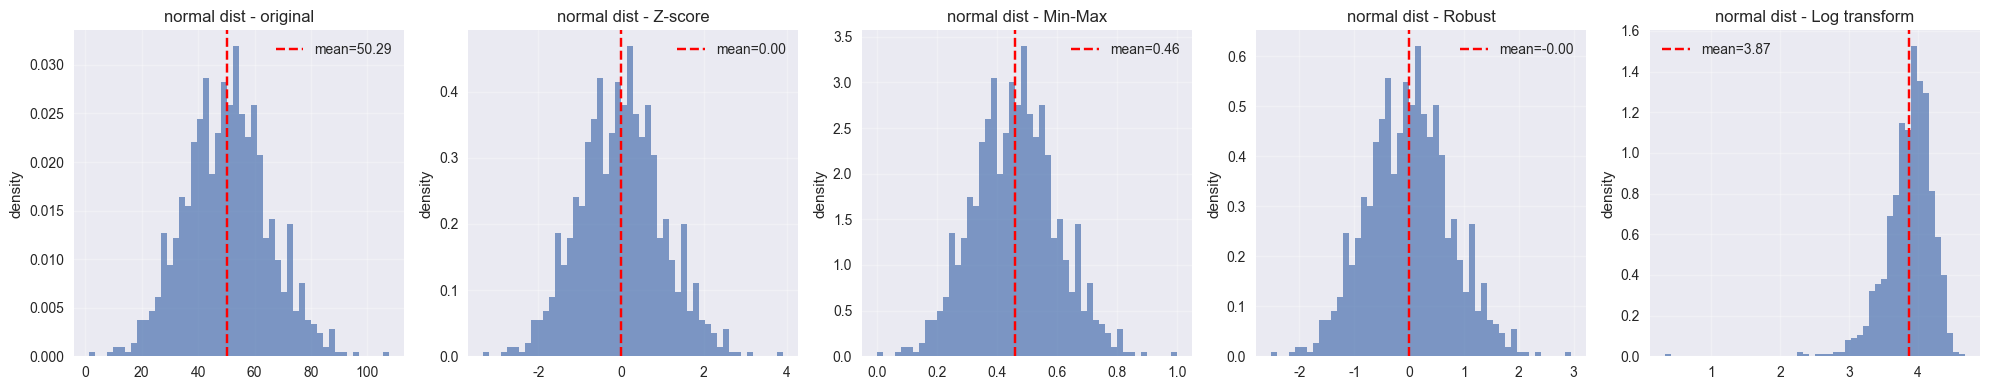


skewed dist 데이터 분석:
----------------------------------------
original: 평균= 23.54, 표준편차= 12.34, 왜도=  1.57
Z-score : 평균=  0.00, 표준편차=  1.00, 왜도=  1.57
Min-Max : 평균=  0.20, 표준편차=  0.13, 왜도=  1.57
Robust  : 평균=  0.20, 표준편차=  0.88, 왜도=  1.57
Log transform: 평균=  3.04, 표준편차=  0.50, 왜도= -0.05


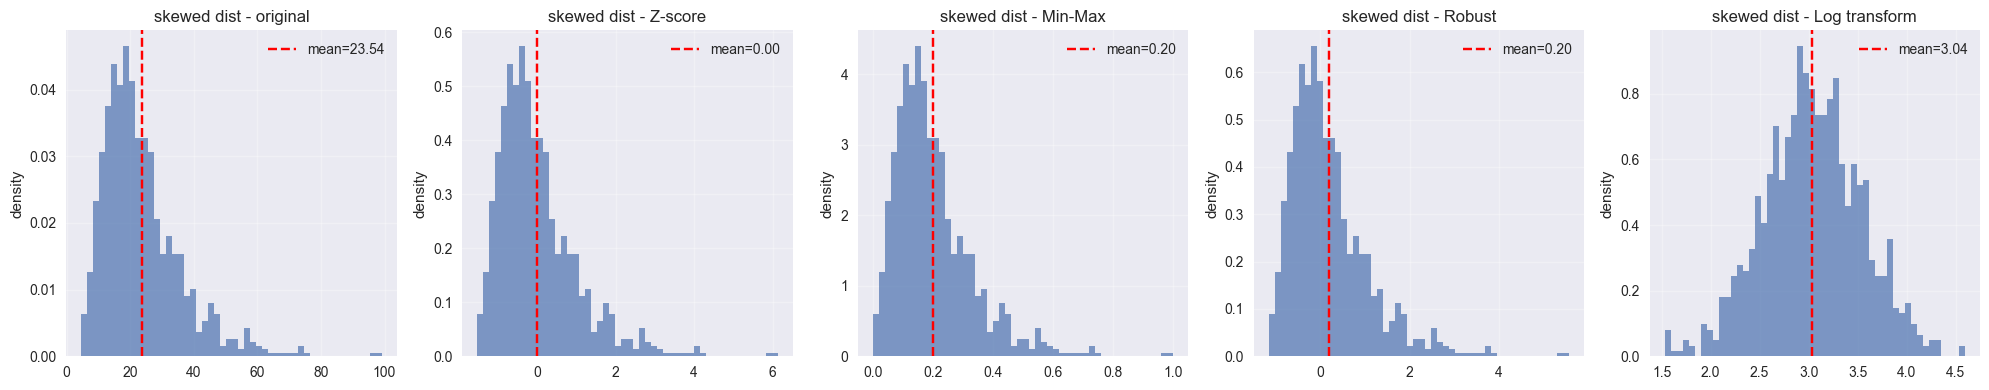


with outlier 데이터 분석:
----------------------------------------
original: 평균= 24.02, 표준편차= 18.12, 왜도=  3.66
Z-score : 평균=  0.00, 표준편차=  1.00, 왜도=  3.66
Min-Max : 평균=  0.19, 표준편차=  0.18, 왜도=  3.66
Robust  : 평균=  0.55, 표준편차=  2.65, 왜도=  3.66
Log transform: 평균=  3.05, 표준편차=  0.44, 왜도=  1.78


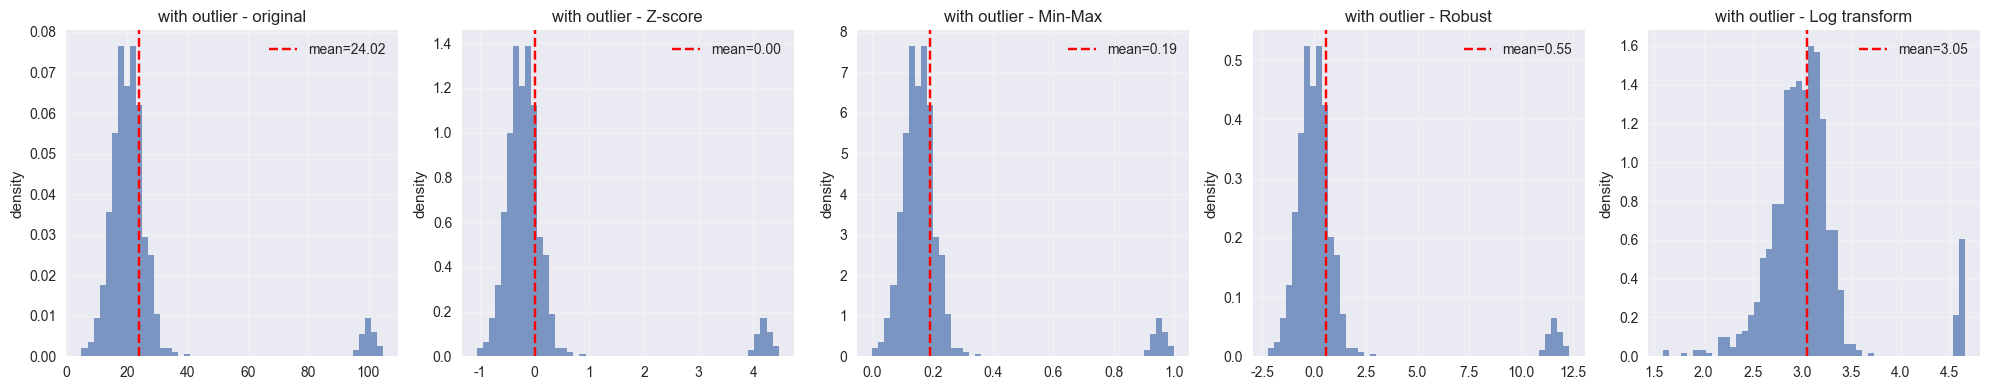

In [18]:
def analyze_preprocessing_methods():
    """다양한 전처리 방법의 통계적 효과 분석"""
    
    # 다양한 분포를 가진 데이터 생성
    np.random.seed(42)
    
    # 1. 정규분포 데이터
    normal_data = np.random.normal(50, 15, 1000)
    
    # 2. 오른쪽 치우친 데이터 (로그정규분포)
    skewed_data = np.random.lognormal(3, 0.5, 1000)
    
    # 3. 이상치가 있는 데이터
    outlier_data = np.concatenate([
        np.random.normal(20, 5, 950),
        np.random.normal(100, 2, 50)  # 이상치
    ])
    
    datasets = {
        'normal dist': normal_data,
        'skewed dist': skewed_data,
        'with outlier': outlier_data
    }
    
    # 전처리 방법들
    def apply_preprocessing(data):
        """다양한 전처리 방법 적용"""
        results = {}
        
        # 원본
        results['original'] = data
        
        # Z-점수 정규화
        scaler = StandardScaler()
        results['Z-score'] = scaler.fit_transform(data.reshape(-1, 1)).flatten()
        
        # Min-Max 스케일링
        minmax = MinMaxScaler()
        results['Min-Max'] = minmax.fit_transform(data.reshape(-1, 1)).flatten()
        
        # 로버스트 스케일링
        robust = RobustScaler()
        results['Robust'] = robust.fit_transform(data.reshape(-1, 1)).flatten()
        
        # 로그 변환 (양수 데이터만)
        if np.all(data > 0):
            results['Log transform'] = np.log(data)
        
        return results
    
    # 각 데이터셋에 대해 전처리 효과 분석
    for name, data in datasets.items():
        print(f"\n{name} 데이터 분석:")
        print("-" * 40)
        
        processed = apply_preprocessing(data)
        
        # 통계량 계산
        for method, transformed_data in processed.items():
            mean_val = np.mean(transformed_data)
            std_val = np.std(transformed_data)
            skew_val = stats.skew(transformed_data)
            
            print(f"{method:8s}: 평균={mean_val:6.2f}, 표준편차={std_val:6.2f}, "
                  f"왜도={skew_val:6.2f}")
        
        # 시각화
        n_methods = len(processed)
        fig, axes = plt.subplots(1, n_methods, figsize=(4*n_methods, 4))
        if n_methods == 1:
            axes = [axes]
        
        for i, (method, transformed_data) in enumerate(processed.items()):
            axes[i].hist(transformed_data, bins=50, alpha=0.7, density=True)
            axes[i].set_title(f'{name} - {method}')
            axes[i].set_ylabel('density')
            axes[i].grid(True, alpha=0.3)
            
            # 통계량 표시
            axes[i].axvline(np.mean(transformed_data), color='red', 
                          linestyle='--', label=f'mean={np.mean(transformed_data):.2f}')
            axes[i].legend()
        
        plt.tight_layout()
        plt.show()

analyze_preprocessing_methods()

5. 실제 데이터셋으로 전처리 실습

원본 데이터 기초 통계:
       temperature     pressure    vibration     humidity
count  1000.000000  1000.000000  1000.000000  1000.000000
mean     25.096660     7.891386     0.575982    59.700258
std       4.896080     2.398435     0.347039    15.352831
min       8.793663     3.058374     0.198049    16.058270
25%      21.762048     6.160313     0.439103    48.938693
50%      25.126503     7.530212     0.505033    60.002769
75%      28.239719     9.195046     0.576049    70.004181
max      44.263657    19.258110     2.482335   100.000000


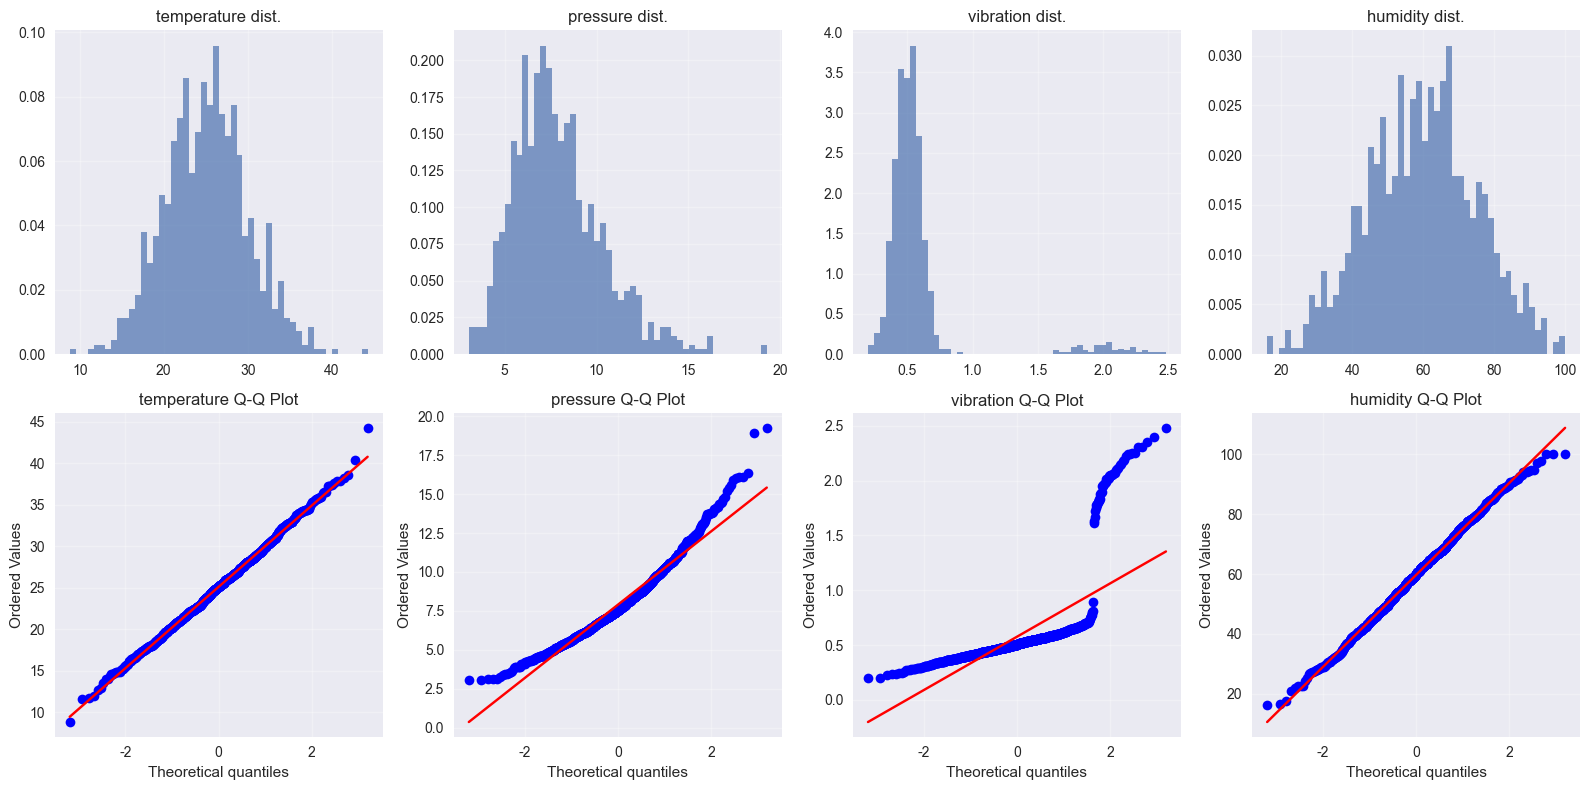


temperature 데이터 특성:
  정규성: Yes (p-value: 0.6552)
  왜도: 0.117
  이상치: 8개 (0.8%)
  추천 전처리: Standard Scaling

pressure 데이터 특성:
  정규성: Yes (p-value: 0.1005)
  왜도: 0.878
  이상치: 24개 (2.4%)
  추천 전처리: Standard Scaling

vibration 데이터 특성:
  정규성: Yes (p-value: 0.7130)
  왜도: 3.730
  이상치: 57개 (5.7%)
  추천 전처리: Robust Scaling

humidity 데이터 특성:
  정규성: Yes (p-value: 0.4174)
  왜도: -0.029
  이상치: 2개 (0.2%)
  추천 전처리: Standard Scaling

전처리 후 데이터:
        temperature      pressure    vibration      humidity
count  1.000000e+03  1.000000e+03  1000.000000  1.000000e+03
mean  -1.056932e-16  1.172396e-16     0.518077  3.339551e-16
std    1.000500e+00  1.000500e+00     2.534133  1.000500e+00
min   -3.331472e+00 -2.016077e+00    -2.241647 -2.844024e+00
25%   -6.814187e-01 -7.221122e-01    -0.481428 -7.013006e-01
50%    6.098290e-03 -1.506625e-01     0.000000  1.971373e-02
75%    6.422755e-01  5.438182e-01     0.518572  6.714774e-01
max    3.916723e+00  4.741597e+00    14.438567  2.626220e+00


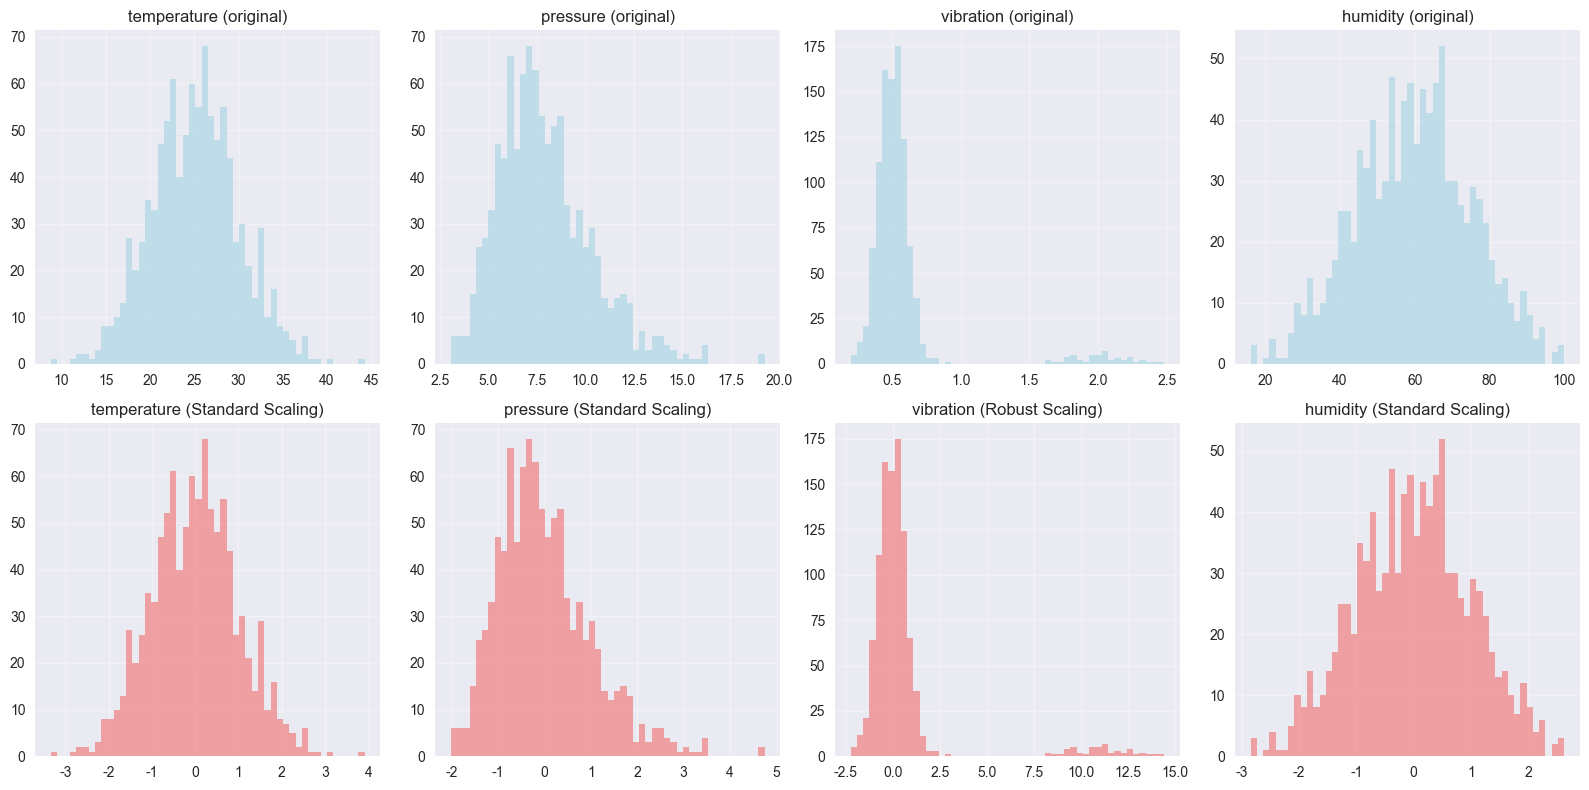

In [24]:
def real_data_preprocessing():
    """실제 데이터셋으로 전처리 방법 선택 기준 학습"""
    
    # 가상의 센서 데이터 생성 (산업 데이터 모방)
    np.random.seed(42)
    n_samples = 1000
    
    # 온도 센서 (정규분포)
    temperature = np.random.normal(25, 5, n_samples)
    
    # 압력 센서 (로그정규분포 - 물리적으로 양수)
    pressure = np.random.lognormal(2, 0.3, n_samples)
    
    # 진동 센서 (이상치 포함)
    vibration = np.concatenate([
        np.random.normal(0.5, 0.1, 950),
        np.random.normal(2.0, 0.2, 50)  # 기계 이상시 진동 증가
    ])
    
    # 습도 센서 (0-100% 범위 제한)
    humidity = np.clip(np.random.normal(60, 15, n_samples), 0, 100)
    
    # 데이터프레임 생성
    df = pd.DataFrame({
        'temperature': temperature,
        'pressure': pressure,
        'vibration': vibration,
        'humidity': humidity
    })
    
    print("원본 데이터 기초 통계:")
    print(df.describe())
    
    # 각 변수별 분포 확인
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    for i, column in enumerate(df.columns):
        # 히스토그램
        axes[0, i].hist(df[column], bins=50, alpha=0.7, density=True)
        axes[0, i].set_title(f'{column} dist.')
        axes[0, i].grid(True, alpha=0.3)
        
        # Q-Q plot (정규성 검정)
        stats.probplot(df[column], dist="norm", plot=axes[1, i])
        axes[1, i].set_title(f'{column} Q-Q Plot')
        axes[1, i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 전처리 방법 선택 및 적용
    def choose_preprocessing(data, column_name):
        """데이터 특성에 따른 전처리 방법 선택"""
    
        # pandas Series를 numpy array로 변환
        data_array = data.values  # 이 부분 추가!
    
        # 정규성 검정
        _, p_value = stats.shapiro(data_array[:100])  # 샘플 크기 제한
        is_normal = p_value > 0.05
    
        # 왜도 계산
        skewness = stats.skew(data_array)
    
        # 이상치 검출 (IQR 방법)
        Q1 = np.percentile(data_array, 25)
        Q3 = np.percentile(data_array, 75)
        IQR = Q3 - Q1
        outlier_threshold = 1.5 * IQR
        outliers = np.sum((data_array < Q1 - outlier_threshold) | 
                     (data_array > Q3 + outlier_threshold))
        has_outliers = outliers > len(data_array) * 0.05
    
        print(f"\n{column_name} 데이터 특성:")
        print(f"  정규성: {'Yes' if is_normal else 'No'} (p-value: {p_value:.4f})")
        print(f"  왜도: {skewness:.3f}")
        print(f"  이상치: {outliers}개 ({outliers/len(data_array)*100:.1f}%)")
    
        # 전처리 방법 선택 로직
        if has_outliers:
            method = "Robust Scaling"
            scaler = RobustScaler()
            transformed = scaler.fit_transform(data_array.reshape(-1, 1)).flatten()
        elif abs(skewness) > 1 and np.all(data_array > 0):
            method = "Log + Standard Scaling"
            log_data = np.log(data_array)
            scaler = StandardScaler()
            transformed = scaler.fit_transform(log_data.reshape(-1, 1)).flatten()
        elif is_normal:
            method = "Standard Scaling"
            scaler = StandardScaler()
            transformed = scaler.fit_transform(data_array.reshape(-1, 1)).flatten()
        else:
            method = "Min-Max Scaling"
            scaler = MinMaxScaler()
            transformed = scaler.fit_transform(data_array.reshape(-1, 1)).flatten()
    
        print(f"  추천 전처리: {method}")
        return transformed, method
    
    # 각 변수별 최적 전처리 적용
    processed_df = pd.DataFrame()
    preprocessing_methods = {}
    
    for column in df.columns:
        transformed_data, method = choose_preprocessing(df[column], column)
        processed_df[column] = transformed_data
        preprocessing_methods[column] = method
    
    print(f"\n전처리 후 데이터:")
    print(processed_df.describe())
    
    # 전처리 전후 비교 시각화
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    for i, column in enumerate(df.columns):
        # 전처리 전
        axes[0, i].hist(df[column], bins=50, alpha=0.7, color='lightblue')
        axes[0, i].set_title(f'{column} (original)')
        axes[0, i].grid(True, alpha=0.3)
        
        # 전처리 후
        axes[1, i].hist(processed_df[column], bins=50, alpha=0.7, color='lightcoral')
        axes[1, i].set_title(f'{column} ({preprocessing_methods[column]})')
        axes[1, i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return df, processed_df, preprocessing_methods
original_df, processed_df, methods = real_data_preprocessing()


6. 딥러닝 관점에서의 전처리 중요성

원본 데이터 스케일:
X1: 평균=0.019, 표준편차=0.979
X2: 평균=1014.167, 표준편차=199.391
X3: 평균=0.001, 표준편차=0.000

before preprocess:
그래디언트 크기: ['-5.784417', '-3.921186', '-5976.409490', '-0.005885']
그래디언트 표준편차: 2586.460329

after preprocess:
그래디언트 크기: ['-6.159924', '-3.874891', '-0.678194', '-0.487047']
그래디언트 표준편차: 2.360948


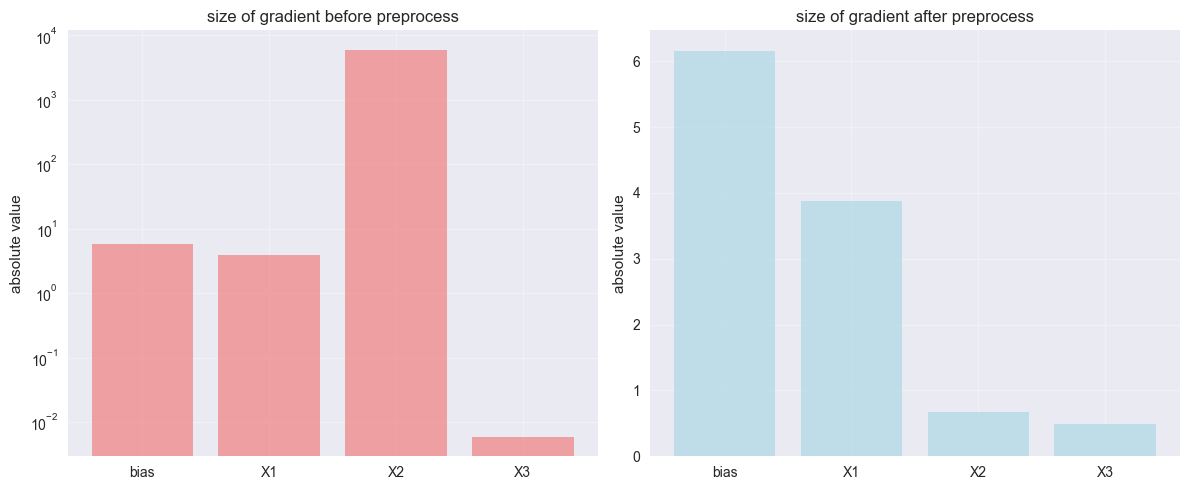


결론:
- 전처리 전: 그래디언트 크기가 특성별로 크게 다름
- 전처리 후: 그래디언트 크기가 비슷한 스케일
- 이는 학습 안정성과 수렴 속도에 큰 영향을 미침


In [28]:
def demonstrate_preprocessing_importance():
    """전처리가 딥러닝 모델에 미치는 영향 시뮬레이션"""
    
    # 간단한 선형 회귀 시뮬레이션
    np.random.seed(42)
    
    # 서로 다른 스케일의 특성 생성
    n_samples = 1000
    X1 = np.random.normal(0, 1, n_samples)          # 표준 스케일
    X2 = np.random.normal(1000, 200, n_samples)     # 큰 스케일
    X3 = np.random.normal(0.001, 0.0002, n_samples) # 작은 스케일
    
    # 타겟 변수 (각 특성이 동일한 중요도)
    y = 2*X1 + 0.002*X2 + 1000*X3 + np.random.normal(0, 0.1, n_samples)
    
    X = np.column_stack([X1, X2, X3])
    
    print("원본 데이터 스케일:")
    for i in range(3):
        print(f"X{i+1}: 평균={np.mean(X[:, i]):.3f}, 표준편차={np.std(X[:, i]):.3f}")
    
    # 그래디언트 계산 시뮬레이션 (실제 경사하강법은 아니지만 개념적으로)
    def simulate_gradient_effect(X, y, title):
        """전처리 전후 그래디언트 스케일 비교"""
        
        # 간단한 선형 모델: y = w0 + w1*x1 + w2*x2 + w3*x3
        w = np.random.normal(0, 0.01, 4)  # 가중치 초기화
        X_with_bias = np.column_stack([np.ones(len(X)), X])
        
        # 예측값 계산
        y_pred = X_with_bias @ w
        
        # 그래디언트 계산 (실제 공식)
        gradient = -2 * X_with_bias.T @ (y - y_pred) / len(X)
        
        print(f"\n{title}:")
        print(f"그래디언트 크기: {[f'{g:.6f}' for g in gradient]}")
        print(f"그래디언트 표준편차: {np.std(gradient):.6f}")
        
        return gradient
    
    # 전처리 전 그래디언트
    grad_before = simulate_gradient_effect(X, y, "before preprocess")
    
    # 전처리 후 그래디언트
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    grad_after = simulate_gradient_effect(X_scaled, y, "after preprocess")
    
    # 그래디언트 크기 비교 시각화
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    feature_names = ['bias', 'X1', 'X2', 'X3']
    plt.bar(feature_names, np.abs(grad_before), alpha=0.7, color='lightcoral')
    plt.title('size of gradient before preprocess')
    plt.ylabel('absolute value')
    plt.yscale('log')  # 로그 스케일로 표시
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.bar(feature_names, np.abs(grad_after), alpha=0.7, color='lightblue')
    plt.title('size of gradient after preprocess')
    plt.ylabel('absolute value')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n결론:")
    print("- 전처리 전: 그래디언트 크기가 특성별로 크게 다름")
    print("- 전처리 후: 그래디언트 크기가 비슷한 스케일")
    print("- 이는 학습 안정성과 수렴 속도에 큰 영향을 미침")

demonstrate_preprocessing_importance()

In [29]:
print("\n오늘 배운 내용:")
print("✓ 정규분포, 베르누이분포, 다항분포의 시뮬레이션")
print("✓ 중심극한정리의 시각적 확인")
print("✓ 다양한 데이터 전처리 방법의 통계적 효과")
print("✓ 데이터 특성에 따른 전처리 방법 선택 기준")
print("✓ 딥러닝에서 전처리의 중요성")
print("\n내일 예고: KL Divergence와 정보 이론")
print("- 두 분포 간 거리 측정")
print("- 정보 이론의 기본 개념")
print("- VAE ELBO 유도 준비")


오늘 배운 내용:
✓ 정규분포, 베르누이분포, 다항분포의 시뮬레이션
✓ 중심극한정리의 시각적 확인
✓ 다양한 데이터 전처리 방법의 통계적 효과
✓ 데이터 특성에 따른 전처리 방법 선택 기준
✓ 딥러닝에서 전처리의 중요성

내일 예고: KL Divergence와 정보 이론
- 두 분포 간 거리 측정
- 정보 이론의 기본 개념
- VAE ELBO 유도 준비
